In [36]:
# Install required packages (if needed)
!pip install --upgrade lightgbm pandas numpy scikit-learn ipywidgets matplotlib
!pip install --upgrade psutil



  Using cached numpy-2.2.5-cp311-cp311-macosx_10_9_x86_64.whl.metadata (62 kB)


In [37]:

# Import libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, # Regression metrics
    accuracy_score, classification_report, confusion_matrix # Classification metrics
)
from sklearn.preprocessing import LabelEncoder # For encoding target variable
from IPython.display import FileLink, display, HTML
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns # For confusion matrix heatmap


# Set random seed for reproducibility
np.random.seed(42)

# ======================
# 1. Generate Synthetic Dataset
# ======================
print("1. Generating Synthetic Dataset...")
n_samples = 1000
data = pd.DataFrame({
    # Soil properties
    "soil_moisture": np.random.uniform(20, 80, n_samples),
    "soil_ph": np.random.uniform(5.0, 8.0, n_samples),
    "soil_nitrogen": np.random.uniform(10, 100, n_samples),
    "soil_type": np.random.choice(["clay", "loam", "sandy"], n_samples),

    # Weather
    "temperature": np.random.uniform(10, 35, n_samples),
    "rainfall": np.random.uniform(0, 50, n_samples),
    "humidity": np.random.uniform(40, 90, n_samples),

    # Pesticide/fertilizer
    "pesticide_type": np.random.choice(["organic", "chemical", "none"], n_samples),
    "pesticide_amount": np.random.exponential(5, n_samples).round(1),
    "fertilizer_amount": np.random.uniform(0, 20, n_samples),

    # Crop
    "crop_type": np.random.choice(["wheat", "corn", "soybean"], n_samples),
    "growth_days": np.random.randint(30, 120, n_samples),
})

# --- Simulate crop yield (target 1) ---
# (Yield simulation remains the same)
data["crop_yield"] = (
    1000 + 10 * data["soil_moisture"] - 5 * (data["soil_ph"] - 6.5)**2
    + 0.5 * data["soil_nitrogen"] - 2 * data["pesticide_amount"]
    + 3 * data["fertilizer_amount"] + 15 * (data['soil_type'] == 'loam')
    - 10 * (data['soil_type'] == 'sandy') + 5 * (data['temperature'] - 20)
    - 3 * (data['temperature'] - 25)**2 + 0.5 * data['rainfall']
    + np.random.normal(0, 50, n_samples)
).astype(int)
data['crop_yield'] = data['crop_yield'].clip(lower=500)
# Interactions
data.loc[(data['crop_type'] == 'corn') & (data['pesticide_type'] == 'chemical'), 'crop_yield'] *= 1.05
data.loc[(data['crop_type'] == 'wheat') & (data['pesticide_type'] == 'organic'), 'crop_yield'] *= 1.03
data.loc[(data['crop_type'] == 'soybean') & (data['temperature'] > 28), 'crop_yield'] *= 0.95

# --- Simulate Mutation Risk (target 2) ---
# (Mutation risk simulation remains the same)
base_risk = np.zeros(n_samples)
base_risk[data['pesticide_type'] == 'chemical'] = 0.4
base_risk[data['pesticide_type'] == 'organic'] = 0.1
temp_factor = ((data['temperature'] - 15) / 20).clip(0, 1)
risk_increase_from_temp = temp_factor * 0.2
amount_factor = np.log1p(data['pesticide_amount']) / np.log1p(data['pesticide_amount'].max())
risk_increase_from_amount = amount_factor * 0.15
pesticide_used = data['pesticide_type'] != 'none'
data['mutation_risk'] = base_risk + (risk_increase_from_temp + risk_increase_from_amount) * pesticide_used
data['mutation_risk'] += np.random.normal(0, 0.05, n_samples)
data['mutation_risk'] = data['mutation_risk'].clip(0, 0.9)

# --- Define an "Optimal" Crop (target 3) - simplified for demonstration ---
# Let's create a rule based on which crop *might* be better suited,
# This is what the crop selection model will try to learn.
# Example rules (can be more complex in reality):
# - Corn likes warmer temps and loam soil.
# - Wheat prefers moderate temps and less sensitive to soil.
# - Soybean prefers moderate temps, sensitive to high heat, okay with various soils.
conditions = [
    (data['temperature'] > 22) & (data['soil_type'] == 'loam'),                  # Good for Corn
    (data['temperature'] < 18),                                                 # Good for Wheat
    (data['temperature'] >= 18) & (data['temperature'] <= 28) & (data['soil_ph'] < 7.0) # Good for Soybean
]
choices = ['corn', 'wheat', 'soybean']
# Assign based on rules, with a default (e.g., wheat if no specific condition met)
data['optimal_crop_target'] = np.select(conditions, choices, default='wheat')
# Add some noise/randomness so it's not perfectly deterministic
random_choice_mask = np.random.rand(n_samples) < 0.15 # 15% chance to pick randomly
data.loc[random_choice_mask, 'optimal_crop_target'] = np.random.choice(choices, size=random_choice_mask.sum())
print(f"   Simulated 'optimal_crop_target' column added.")


# Save to CSV
csv_filename = "farm_data_with_3_targets.csv"
data.to_csv(csv_filename, index=False)
print(f"   Dataset saved to {csv_filename}")

# Label Encode the target crop type for classification models
label_encoder_crop = LabelEncoder()
data['optimal_crop_target_encoded'] = label_encoder_crop.fit_transform(data['optimal_crop_target'])
crop_classes = label_encoder_crop.classes_
print(f"   Crop types encoded: {dict(zip(crop_classes, label_encoder_crop.transform(crop_classes)))}")


1. Generating Synthetic Dataset...
   Simulated 'optimal_crop_target' column added.
   Dataset saved to farm_data_with_3_targets.csv
   Crop types encoded: {'corn': 0, 'soybean': 1, 'wheat': 2}


In [38]:


# ============================================================
# 2. Preprocess Data & Train CROP YIELD Model
# ============================================================
print("\n2. Preprocessing & Training YIELD Model...")
# Features for yield model (all relevant factors)
yield_model_features = [col for col in data.columns if col not in ['crop_yield', 'mutation_risk', 'optimal_crop_target', 'optimal_crop_target_encoded']]
X_yield = pd.get_dummies(data[yield_model_features])
y_yield = data["crop_yield"]
X_yield_train, X_yield_test, y_yield_train, y_yield_test = train_test_split(
    X_yield, y_yield, test_size=0.2, random_state=42
)
# Train Yield Model (using user-specified parameters)
yield_model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=1000,
                                reg_alpha=0.1, n_jobs=1, verbose=-1) # Quieter verbose
yield_model.fit(X_yield_train, y_yield_train, eval_set=[(X_yield_test, y_yield_test)],
                eval_metric="mae", callbacks=[lgb.early_stopping(100, verbose=False)]) # Use early stopping here
print("   Yield Model training complete.")
mae_yield = mean_absolute_error(y_yield_test, yield_model.predict(X_yield_test))
print(f"   Yield Model MAE: {mae_yield:.2f}")


2. Preprocessing & Training YIELD Model...
   Yield Model training complete.
   Yield Model MAE: 52.84


In [39]:
# ============================================================
# 3. Preprocess Data & Train MUTATION RISK Model
# ============================================================
print("\n3. Preprocessing & Training MUTATION RISK Model...")
# Features for mutation risk (pesticide, weather, crop)
mutation_features = ["pesticide_type", "pesticide_amount", "temperature", "crop_type", "growth_days"]
X_mutation = pd.get_dummies(data[mutation_features])
y_mutation = data["mutation_risk"]
X_mutation_train, X_mutation_test, y_mutation_train, y_mutation_test = train_test_split(
    X_mutation, y_mutation, test_size=0.2, random_state=42
)
# Train Mutation Risk Model
mutation_model = lgb.LGBMRegressor(
    num_leaves=20,
    learning_rate=0.05,
    n_estimators=500,
    reg_alpha=0.1,
    # n_jobs=-1,              # <--- CHANGE THIS LINE
    n_jobs=1,                 # <--- TO THIS (Avoids cpu_count error)
    random_state=42,
    verbose=-1               # Keep this one quiet during training
    )

# Use early stopping for the mutation model training
callbacks_mut = [lgb.early_stopping(50, verbose=False)]

mutation_model.fit(
    X_mutation_train, y_mutation_train,
    eval_set=[(X_mutation_test, y_mutation_test)],
    eval_metric="rmse", # Use RMSE for risk prediction evaluation
    callbacks=callbacks_mut
)
print("   Mutation Risk Model training complete.")
rmse_mutation = mean_squared_error(y_mutation_test, mutation_model.predict(X_mutation_test), squared=False)
print(f"   Mutation Model RMSE: {rmse_mutation:.4f}")


3. Preprocessing & Training MUTATION RISK Model...
   Mutation Risk Model training complete.
   Mutation Model RMSE: 0.0495



4. Preprocessing & Training CROP SELECTION Model...
   Crop Selection Training data shape: (800, 9)
   Crop Selection Model training complete.

5. Evaluating CROP SELECTION Model...
   Crop Selection Model Accuracy: 0.880
   Classification Report:
              precision    recall  f1-score   support

        corn       0.94      0.77      0.85        39
     soybean       0.86      0.71      0.78        45
       wheat       0.87      0.98      0.92       116

    accuracy                           0.88       200
   macro avg       0.89      0.82      0.85       200
weighted avg       0.88      0.88      0.88       200



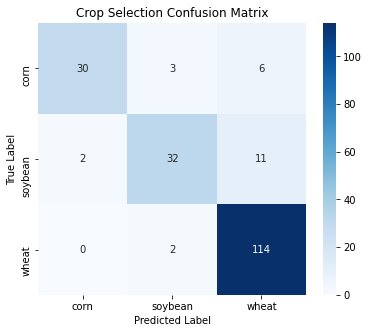

In [40]:



# ============================================================
# 4. Preprocess Data & Train CROP SELECTION Model
# ============================================================
print("\n4. Preprocessing & Training CROP SELECTION Model...")
# Features for crop selection (Soil and Weather ONLY)
crop_selection_features = ["soil_moisture", "soil_ph", "soil_nitrogen", "soil_type",
                           "temperature", "rainfall", "humidity"]
X_crop = pd.get_dummies(data[crop_selection_features])
# Use the ENCODED optimal crop as the target
y_crop = data['optimal_crop_target_encoded']

X_crop_train, X_crop_test, y_crop_train, y_crop_test = train_test_split(
    X_crop, y_crop, test_size=0.2, random_state=42, stratify=y_crop # Stratify for classification
)
print(f"   Crop Selection Training data shape: {X_crop_train.shape}")

# Train Crop Selection Model (Classifier)
crop_selection_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(crop_classes), # Number of crop types
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=25,
    n_jobs=1,
    random_state=42,
    # verbose=-1
)

crop_selection_model.fit(
    X_crop_train, y_crop_train,
    eval_set=[(X_crop_test, y_crop_test)],
    eval_metric='multi_logloss', # Metric for multiclass classification
    callbacks=[lgb.early_stopping(50, verbose=False)]
)
print("   Crop Selection Model training complete.")

# Evaluate Crop Selection Model
print("\n5. Evaluating CROP SELECTION Model...")
y_crop_pred_encoded = crop_selection_model.predict(X_crop_test)
y_crop_pred_labels = label_encoder_crop.inverse_transform(y_crop_pred_encoded)
y_crop_test_labels = label_encoder_crop.inverse_transform(y_crop_test)

accuracy_crop = accuracy_score(y_crop_test, y_crop_pred_encoded)
print(f"   Crop Selection Model Accuracy: {accuracy_crop:.3f}")
print("   Classification Report:")
print(classification_report(y_crop_test_labels, y_crop_pred_labels, target_names=crop_classes))

# Optional: Confusion Matrix Plot
cm = confusion_matrix(y_crop_test_labels, y_crop_pred_labels, labels=crop_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=crop_classes, yticklabels=crop_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Crop Selection Confusion Matrix')
plt.show()


In [41]:


# ======================
# 6. Define Helper Functions 
# ======================
print("\n6. Defining Recommendation Helpers...")
def get_active_name(row, prefix, categories):
    for cat in categories:
        col_name = f"{prefix}{cat}"
        if col_name in row and row[col_name] == 1: return cat
    original_col = prefix.replace('_', '')
    if original_col in row: return row[original_col]
    return 'unknown'

def calculate_disease_risk(avg_humidity, active_crop, active_pesticide):
    risk = 0
    if avg_humidity > 70: risk += 0.3
    elif avg_humidity > 60: risk += 0.15
    if active_crop == 'corn': risk += 0.2
    elif active_crop == 'soybean': risk += 0.1
    if active_pesticide == 'none': risk += 0.3
    elif active_pesticide == 'chemical': risk -= 0.05
    return max(0, min(risk, 0.95))




6. Defining Recommendation Helpers...


In [42]:

# ============================================================
# 7. Enhanced Recommendation Engine (Using ALL THREE Models)
# ============================================================
print("\n7. Defining Enhanced Recommendation Engine (using ALL 3 models)...")
def get_enhanced_recommendations(
    input_data_dict, # Take dict as input now
    crop_selection_model, # <-- New model
    yield_model,
    mutation_model,
    original_data,
    weather_forecast,
    label_encoder_crop, # <-- Pass encoder
    X_crop_train_cols,   # <-- Columns for crop model
    X_yield_train_cols,
    X_mutation_train_cols
    ):
    """
    Generate recommendations:
    1. Predict best crop using crop_selection_model based on soil/weather.
    2. Simulate pesticide options ONLY for the predicted best crop.
    3. Use yield_model and mutation_model for those scenarios.
    4. Rank based on score (profit * (1-disease) * (1-mutation)).
    """
    input_df = pd.DataFrame([input_data_dict])

    # --- Predict Best Crop First ---
    print("   Step 1: Predicting best crop based on soil/weather...")
    # Prepare input for crop selection model (only soil/weather features)
    input_crop_features = input_df[[col for col in X_crop_train_cols if col.split('_')[0] in input_df.columns]]
    input_crop_processed = pd.get_dummies(input_crop_features)
    # Align columns with training data for crop model
    missing_crop_cols = set(X_crop_train_cols) - set(input_crop_processed.columns)
    for col in missing_crop_cols: input_crop_processed[col] = 0
    input_crop_processed = input_crop_processed[X_crop_train_cols]

    # Predict the single best crop (encoded)
    predicted_crop_encoded = crop_selection_model.predict(input_crop_processed)[0]
    # Decode to get the crop name
    predicted_best_crop = label_encoder_crop.inverse_transform([predicted_crop_encoded])[0]
    print(f"   Crop Selection Model recommends: {predicted_best_crop.upper()}")
    # --- End Crop Prediction ---


    # 1. Get unique options and calculate weather averages
    # crops = sorted(original_data['crop_type'].unique()) # No longer need all crops
    pesticides = sorted(original_data['pesticide_type'].unique())
    soil_types = sorted(original_data['soil_type'].unique()) # Still need for yield model encoding

    avg_temp = np.mean([w['temp'] for w in weather_forecast]) if weather_forecast else 20
    total_rain = np.sum([w['precip'] for w in weather_forecast]) if weather_forecast else 10
    avg_humidity = np.mean([w['humidity'] for w in weather_forecast]) if weather_forecast else 60

    # 2. Create base scenario from input
    base_scenario = input_data_dict.copy() # Use the input dictionary
    base_scenario.update({
        'temperature': avg_temp, 'rainfall': total_rain,
        'humidity': avg_humidity, 'growth_days': 90
    })

    # 3. Generate scenarios ONLY for the predicted best crop
    print(f"   Step 2: Simulating pesticide options for {predicted_best_crop.upper()}...")
    scenarios_list = []
    # The crop is now fixed based on the crop_selection_model prediction
    base_scenario['crop_type'] = predicted_best_crop
    for pesticide in pesticides:
        scenario = base_scenario.copy()
        scenario['pesticide_type'] = pesticide
        # Ensure soil_type is included
        scenario['soil_type'] = base_scenario['soil_type']
        scenarios_list.append(scenario)

    if not scenarios_list:
        print("Error: No scenarios generated. Check input and model predictions.")
        return None # Handle error case

    scenarios_df = pd.DataFrame(scenarios_list)
    # Keep original categories for later use if needed
    scenarios_df_orig_cats = scenarios_df[['crop_type', 'pesticide_type', 'soil_type']].copy()


    # 4. Prepare data for Yield and Mutation models
    # 4a. For Yield Model
    scenarios_yield_processed = pd.get_dummies(scenarios_df, columns=['crop_type', 'pesticide_type', 'soil_type'])
    missing_yield_cols = set(X_yield_train_cols) - set(scenarios_yield_processed.columns)
    for col in missing_yield_cols: scenarios_yield_processed[col] = 0
    scenarios_yield_processed = scenarios_yield_processed[X_yield_train_cols]

    # 4b. For Mutation Model
    mutation_model_input_cols = [col for col in X_mutation_train_cols if col.split('_')[0] in scenarios_df.columns]
    scenarios_mutation_processed = pd.get_dummies(scenarios_df[list(set(mutation_features) & set(scenarios_df.columns))])
    missing_mutation_cols = set(X_mutation_train_cols) - set(scenarios_mutation_processed.columns)
    for col in missing_mutation_cols: scenarios_mutation_processed[col] = 0
    scenarios_mutation_processed = scenarios_mutation_processed[X_mutation_train_cols]

    # 5. Make predictions using Yield and Mutation models
    print("   Step 3: Predicting yield and mutation risk...")
    try:
        scenarios_df['predicted_yield'] = yield_model.predict(scenarios_yield_processed)
        scenarios_df['mutation_risk'] = mutation_model.predict(scenarios_mutation_processed).clip(0, 1)
    except Exception as e:
      print(f"Error during prediction: {e}")
      raise

    # --- Post-prediction analysis ---
    scenarios_df['crop'] = scenarios_df_orig_cats['crop_type'] # Should be the same predicted crop
    scenarios_df['pesticide'] = scenarios_df_orig_cats['pesticide_type']

    # 6. Economic analysis
    crop_prices = {'wheat': 200, 'corn': 180, 'soybean': 220}
    pesticide_costs = {'organic': 50, 'chemical': 30, 'none': 0}
    fertilizer_cost_per_unit = 2
    scenarios_df['revenue'] = scenarios_df.apply(lambda row: row['predicted_yield'] / 1000 * crop_prices.get(row['crop'], 0), axis=1)
    scenarios_df['pesticide_cost'] = scenarios_df.apply(lambda row: pesticide_costs.get(row['pesticide'], 0), axis=1)
    scenarios_df['fertilizer_cost'] = scenarios_df['fertilizer_amount'] * fertilizer_cost_per_unit
    scenarios_df['profit'] = scenarios_df['revenue'] - scenarios_df['pesticide_cost'] - scenarios_df['fertilizer_cost']

    # 7. Disease Risk (rule-based)
    scenarios_df['disease_risk'] = scenarios_df.apply(
        lambda row: calculate_disease_risk(avg_humidity, row['crop'], row['pesticide']), axis=1
    )

    # 8. Find optimal scenario (best pesticide strategy for the chosen crop)
    print("   Step 4: Calculating scores and finding best pesticide strategy...")
    scenarios_df['score'] = scenarios_df['profit'] * (1 - scenarios_df['disease_risk']) * (1 - scenarios_df['mutation_risk'])
    optimal_idx = scenarios_df['score'].idxmax()
    optimal = scenarios_df.loc[optimal_idx]

    # 9. Prepare output
    display_cols = ['pesticide', 'predicted_yield', 'profit', 'disease_risk', 'mutation_risk', 'score'] # Crop is fixed now
    all_options_display = scenarios_df[display_cols].copy()
    # Formatting...
    for col in ['predicted_yield']: all_options_display[col] = all_options_display[col].round(0)
    for col in ['profit', 'score']: all_options_display[col] = all_options_display[col].round(2)
    for col in ['disease_risk', 'mutation_risk']: all_options_display[col] = all_options_display[col].round(3)

    return {
        'predicted_crop': predicted_best_crop, # Add the predicted crop to output
        'recommendation': {
            'crop': optimal['crop'], # Will be the same as predicted_crop
            'pesticide': optimal['pesticide'],
            'expected_yield': optimal['predicted_yield'],
            'expected_profit': optimal['profit'],
            'disease_risk': optimal['disease_risk'],
            'mutation_risk': optimal['mutation_risk'],
            'overall_score': optimal['score']
        },
        'weather_impact': {
            'avg_temp': avg_temp, 'total_rain': total_rain, 'avg_humidity': avg_humidity
        },
        'all_options_for_crop': all_options_display # Options only for the selected crop
    }




7. Defining Enhanced Recommendation Engine (using ALL 3 models)...


In [43]:
import pandas as pd
import numpy as np
# Assuming other necessary imports like your models, encoders, etc., are available

def get_enhanced_recommendations(input_data_dict, crop_selection_model, yield_model, mutation_model,
                                 original_data, weather_forecast, label_encoder_crop,
                                 X_crop_train_cols, X_yield_train_cols, X_mutation_train_cols):
    """
    Enhanced version that first predicts the best crop based on soil/weather,
    then optimizes for that crop by evaluating different strategies (pesticide levels).
    """

    # Convert input dict to DataFrame (single row)
    # Initially, this only contains soil conditions
    input_df = pd.DataFrame([input_data_dict])

    # ==============================================
    # STEP 1: Predict the best crop for these conditions
    # ==============================================
    print("   Step 1: Predicting best crop based on soil/weather...")

    # Calculate representative weather metrics from the forecast
    if weather_forecast:
        avg_temp = sum([d['temp'] for d in weather_forecast]) / len(weather_forecast)
        total_precip = sum([d['precip'] for d in weather_forecast])
        avg_humidity = sum([d['humidity'] for d in weather_forecast]) / len(weather_forecast)
    else:
        print("   Warning: Weather forecast is empty. Using default values (0) for weather.")
        avg_temp = 0
        total_precip = 0
        avg_humidity = 0

    # Add these calculated weather metrics as columns to the input DataFrame
    input_df['temperature'] = avg_temp
    input_df['rainfall'] = total_precip
    input_df['humidity'] = avg_humidity

    # Prepare input for crop selection model (now input_df contains soil AND weather features)
    crop_features = ['soil_moisture', 'soil_ph', 'soil_nitrogen', 'soil_type',
                     'temperature', 'rainfall', 'humidity']

    # Ensure all crop_features exist in input_df before selecting
    # (This is a safeguard; the code above adds weather, soil comes from input_data_dict)
    missing_initial_cols = set(crop_features) - set(input_df.columns)
    if missing_initial_cols:
         print(f"   Error: Missing required initial features for crop prediction: {missing_initial_cols}")
         return None # Or raise an error


    input_crop_features = input_df[crop_features].copy()

    # Get dummies for categorical features (soil_type)
    input_crop_processed = pd.get_dummies(input_crop_features)

    # Align columns with training data for crop model
    # Add missing columns (from training) with 0 values
    for col in X_crop_train_cols:
         if col not in input_crop_processed.columns:
              input_crop_processed[col] = 0

    # Ensure columns are in same order as training
    input_crop_processed = input_crop_processed[X_crop_train_cols]

    # Predict crop type
    predicted_crop_encoded = crop_selection_model.predict(input_crop_processed)[0]
    predicted_crop = label_encoder_crop.inverse_transform([predicted_crop_encoded])[0]
    print(f"      Predicted crop: {predicted_crop}")

    # ==============================================
    # STEP 2: Generate recommendations for this specific crop
    # ==============================================
    print(f"   Step 2: Optimizing strategy for {predicted_crop}...")

    # Add the predicted crop to the input data for the subsequent models
    # This is needed because yield and mutation models depend on crop type
    input_df['crop_type'] = predicted_crop

    # --- Optimization Logic Starts Here ---

    # Get unique pesticide amounts from the training data to test
    # You could also define a specific range or list manually
    if original_data is not None and 'pesticide_amount' in original_data.columns:
        pesticide_options_to_test = sorted(original_data['pesticide_amount'].unique())
    else:
        # Fallback: Define a default set of pesticide amounts if data is unavailable
        print("   Warning: Could not get unique pesticide amounts from original_data. Using default range [0, 25, 50, 75, 100].")
        pesticide_options_to_test = [0, 25, 50, 75, 100]

    # Keep the original fertilizer amount from input data constant for optimization loop
    # You could also loop through fertilizer options if desired
    current_fertilizer_amount = input_df['fertilizer_amount'].iloc[0] # Use .iloc[0] as it's a single row DataFrame


    all_options_results = []

    # Define simple hypothetical formulas for score, profit, disease risk
    # <<< YOU SHOULD REPLACE THESE WITH FORMULAS BASED ON YOUR DOMAIN KNOWLEDGE/DATA >>>
    BASE_PRICE_PER_YIELD_UNIT = 2.5 # $/kg for example
    PESTICIDE_COST_PER_UNIT = 0.8 # $/unit of pesticide_amount
    # Simple inverse relationship with pesticide amount, capped
    def estimate_disease_risk(pesticide_amount):
        max_risk = 0.30 # 30% at 0 pesticide
        min_risk = 0.05 # 5% at high pesticide
        max_pesticide_in_range = max(pesticide_options_to_test) if pesticide_options_to_test else 100
        if max_pesticide_in_range == 0: # Avoid division by zero if only 0 is tested
             return max_risk if pesticide_amount == 0 else min_risk # Or handle based on context
        # Linear decrease from max_risk to min_risk as pesticide goes from 0 to max_pesticide_in_range
        risk = max_risk - (pesticide_amount / max_pesticide_in_range) * (max_risk - min_risk)
        return max(min_risk, min(max_risk, risk)) # Ensure it stays within bounds

    # Score = Yield - (Mutation Risk * Penalty) - (Disease Risk * Penalty) - (Pesticide Cost)
    MUTATION_PENALTY = 800 # Arbitrary penalty value
    DISEASE_PENALTY = 500  # Arbitrary penalty value
    # <<< END HYPOTHETICAL FORMULAS >>>


    print(f"   Evaluating {len(pesticide_options_to_test)} pesticide options...")

    for pest_amount in pesticide_options_to_test:
        # Create input features for yield and mutation models for this specific option
        option_input_data = input_df.copy() # Start with base soil, weather, crop
        option_input_data['pesticide_amount'] = pest_amount
        option_input_data['fertilizer_amount'] = current_fertilizer_amount # Keep fertilizer constant

        # --- Prepare input for Yield model ---
        # Ensure yield_model_features are in option_input_data
        yield_features = list(X_yield_train_cols) # Features used by yield model
        # Add any missing features from option_input_data that yield_features expects
        missing_yield_input = set(yield_features) - set(option_input_data.columns)
        if missing_yield_input:
             print(f"   Warning: Yield model expects features not in option_input_data: {missing_yield_input}. Proceeding, but this may cause errors if they are essential and missing.")


        input_yield_features = option_input_data[list(set(yield_features) & set(option_input_data.columns))].copy() # Select only existing ones first

        # Get dummies for categorical features in yield model input
        input_yield_processed = pd.get_dummies(input_yield_features)

        # Align columns with training data for yield model
        for col in X_yield_train_cols:
             if col not in input_yield_processed.columns:
                  input_yield_processed[col] = 0

        input_yield_processed = input_yield_processed[X_yield_train_cols]

        # Predict yield
        predicted_yield = yield_model.predict(input_yield_processed)[0]
        predicted_yield = max(0, predicted_yield) # Yield cannot be negative

        # --- Prepare input for Mutation model ---
        # Ensure mutation_model_features are in option_input_data
        mutation_features = list(X_mutation_train_cols) # Features used by mutation model
        # Add any missing features from option_input_data that mutation_features expects
        missing_mutation_input = set(mutation_features) - set(option_input_data.columns)
        if missing_mutation_input:
             print(f"   Warning: Mutation model expects features not in option_input_data: {missing_mutation_input}. Proceeding, but this may cause errors if they are essential and missing.")

        input_mutation_features = option_input_data[list(set(mutation_features) & set(option_input_data.columns))].copy() # Select only existing ones first

        # Get dummies for categorical features in mutation model input
        input_mutation_processed = pd.get_dummies(input_mutation_features)

        # Align columns with training data for mutation model
        for col in X_mutation_train_cols:
             if col not in input_mutation_processed.columns:
                  input_mutation_processed[col] = 0

        input_mutation_processed = input_mutation_processed[X_mutation_train_cols]

        # Predict mutation risk (assuming model outputs probability between 0 and 1)
        predicted_mutation_risk = mutation_model.predict(input_mutation_processed)[0]
        predicted_mutation_risk = max(0, min(1, predicted_mutation_risk)) # Ensure risk is between 0 and 1


        # --- Calculate Estimated Profit, Disease Risk, and Score ---
        estimated_disease_risk = estimate_disease_risk(pest_amount) # Using hypothetical function

        # Calculate profit based on yield and costs
        expected_profit = (predicted_yield * BASE_PRICE_PER_YIELD_UNIT) - (pest_amount * PESTICIDE_COST_PER_UNIT)
        # You might also subtract fertilizer cost here if it varied, and other fixed/variable costs

        # Calculate overall score
        overall_score = predicted_yield - (predicted_mutation_risk * MUTATION_PENALTY) - (estimated_disease_risk * DISEASE_PENALTY) - (pest_amount * PESTICIDE_COST_PER_UNIT) # Example score formula

        # Store results for this option
        all_options_results.append({
            'pesticide_amount': pest_amount,
            'fertilizer_amount': current_fertilizer_amount, # Include fertilizer amount
            'Pesticide_Name': f'Pesticide {pest_amount} units', # A name for display
            'Expected_Yield': predicted_yield,
            'Predicted_Mutation_Risk': predicted_mutation_risk,
            'Estimated_Disease_Risk': estimated_disease_risk,
            'Expected_Profit': expected_profit,
            'Overall_Score': overall_score
        })

    # --- Optimization Logic Ends Here ---

    # Convert results to a DataFrame
    all_options_for_crop_df = pd.DataFrame(all_options_results)

    # Find the optimal recommendation (highest score)
    if not all_options_for_crop_df.empty:
        optimal_rec_row = all_options_for_crop_df.loc[all_options_for_crop_df['Overall_Score'].idxmax()]

        # Prepare the optimal recommendation dictionary for the display code
        # Ensure keys match what the display code expects
        optimal_recommendation_dict = {
            'pesticide': optimal_rec_row['Pesticide_Name'], # Use the generated name
            'pesticide_amount': optimal_rec_row['pesticide_amount'], # Also include amount if needed
            'fertilizer_amount': optimal_rec_row['fertilizer_amount'], # Include fertilizer amount
            'expected_yield': optimal_rec_row['Expected_Yield'],
            'expected_profit': optimal_rec_row['Expected_Profit'],
            'disease_risk': optimal_rec_row['Estimated_Disease_Risk'],
            'mutation_risk': optimal_rec_row['Predicted_Mutation_Risk'],
            'overall_score': optimal_rec_row['Overall_Score']
        }
    else:
        optimal_recommendation_dict = {} # Return empty if no options were evaluated
        print("   Warning: No pesticide options evaluated. Optimal recommendation is empty.")


    print("   Recommendation generation complete.")

    # Return the complete set of recommendations
    return {
        'predicted_crop': predicted_crop,
        'initial_conditions': input_data_dict,
        'processed_weather': {
            'avg_temp': avg_temp,
            'total_rainfall': total_precip,
            'avg_humidity': avg_humidity
        },
        'recommendation': optimal_recommendation_dict, # This now contains the best option
        'all_options_for_crop': all_options_for_crop_df # This contains all evaluated options
    }

# Now, when you call get_enhanced_recommendations, it will perform Step 2
# and return the 'recommendation' and 'all_options_for_crop' keys,
# which the display code expects. The display code should now work
# without the KeyError (assuming the models are trained and loaded correctly
# and the column alignment works).

In [44]:
# ======================
# 8. Example Usage
# ======================
print("\n8. Running Example Recommendation with Crop Selection Pre-filter...")
# Current soil conditions
current_soil_conditions = {
    'soil_moisture': 72, 'soil_ph': 6.8, 'soil_nitrogen': 65,
    'pesticide_amount': 0, # Assume planning before pesticide application
    'fertilizer_amount': 15, 'soil_type': 'loam'
}

# Weather forecast (Example where Corn might be favored: warmer, enough rain)
weather_forecast = [
    {'day': 1, 'temp': 24, 'precip': 2, 'humidity': 70}, {'day': 2, 'temp': 25, 'precip': 5, 'humidity': 75},
    {'day': 3, 'temp': 26, 'precip': 0, 'humidity': 68}, {'day': 4, 'temp': 27, 'precip': 1, 'humidity': 72},
    {'day': 5, 'temp': 26, 'precip': 3, 'humidity': 77}, {'day': 6, 'temp': 28, 'precip': 0, 'humidity': 65},
    {'day': 7, 'temp': 27, 'precip': 6, 'humidity': 80},
]

# Generate recommendations using ALL THREE models
recommendations = get_enhanced_recommendations(
    current_soil_conditions,
    crop_selection_model,    # <-- Pass the new model
    yield_model,
    mutation_model,
    data,                    # Original data for unique values
    weather_forecast,
    label_encoder_crop,      # <-- Pass the encoder
    X_crop_train.columns,    # <-- Pass crop model columns
    X_yield_train.columns,
    X_mutation_train.columns
)




8. Running Example Recommendation with Crop Selection Pre-filter...
   Step 1: Predicting best crop based on soil/weather...
      Predicted crop: corn
   Step 2: Optimizing strategy for corn...
   Evaluating 180 pesticide options...


   Recommendation generation complete.


In [48]:
# ======================
# 9. Display Results (Text and Widget)
# ======================
print("\n9. Displaying Results (Crop Pre-Selected)...")

# Assuming 'recommendations' dictionary is available from the call to get_enhanced_recommendations
# Check if recommendations were generated at all
if recommendations:
    # Check if the required keys for full display are present
    if 'predicted_crop' in recommendations and 'recommendation' in recommendations and 'all_options_for_crop' in recommendations:

        predicted_crop = recommendations['predicted_crop']
        optimal_rec = recommendations['recommendation']
        all_options_for_crop_df = recommendations['all_options_for_crop'] # Get the DataFrame directly
        weather_info = recommendations.get('processed_weather', {}) # Safely get weather info

        print(f"\n=== CROP PREDICTION (Based on Soil/Weather) ===")
        print(f"-> Most Suitable Crop Predicted: {predicted_crop.upper()}")

        print(f"\n=== OPTIMAL STRATEGY for {predicted_crop.upper()} ===")
        # Use .get() for safer access in case a key is unexpectedly missing in optimal_rec
        print(f"-> Recommended Pesticide: {optimal_rec.get('pesticide', 'N/A').upper()}")
        print(f"   - Expected Yield: {optimal_rec.get('expected_yield', 0):.0f} kg/ha")
        print(f"   - Expected Profit: ${optimal_rec.get('expected_profit', 0):.2f}/ha") # Corrected syntax
        print(f"   - Estimated Disease Risk: {optimal_rec.get('disease_risk', 0):.1%}")
        print(f"   - Predicted Mutation Risk: {optimal_rec.get('mutation_risk', 0):.1%}")
        print(f"   - Overall Score: {optimal_rec.get('overall_score', 0):.2f}")

        # --- Corrected Weather Display (using 'processed_weather' key and safe access) ---
        print("\n=== WEATHER CONSIDERATIONS (Forecast Period) ===")
        if weather_info: # Check if weather_info dictionary is not empty
            print(f"Average Temperature: {weather_info.get('avg_temp', 0):.1f}°C")
            # Assuming the key in processed_weather is 'total_rainfall'
            print(f"Total Rainfall: {weather_info.get('total_rainfall', 0):.1f} mm")
            print(f"Average Humidity: {weather_info.get('avg_humidity', 0):.1f}%")
        else:
            print("Weather information not available in recommendations.")
        # --- End Corrected Weather Display ---

        # Ensure all_options_for_crop_df is not empty before displaying
        print(f"\n=== PESTICIDE OPTIONS CONSIDERED for {predicted_crop.upper()} (Ranked by Score) ===")
        if not all_options_for_crop_df.empty:
             # Use the DataFrame variable directly
             display(all_options_for_crop_df.sort_values('Overall_Score', ascending=False)) # Make sure 'score' matches the column name in the DataFrame ('Overall_Score' based on previous fix)
        else:
             print("No pesticide options data available.")


    

    else:
        # Case where recommendations dictionary exists but is missing expected keys
        print("\nCould not display full recommendations. Required data keys ('predicted_crop', 'recommendation', 'all_options_for_crop') are missing.")
        # Optionally display predicted crop if that key is available
        if 'predicted_crop' in recommendations:
             predicted_crop = recommendations['predicted_crop']
             print(f"\n=== CROP PREDICTION (Based on Soil/Weather) ===")
             print(f"-> Most Suitable Crop Predicted: {predicted_crop.upper()}")
             # Optionally display weather info here too if available via 'processed_weather'
             weather_info = recommendations.get('processed_weather', {})
             if weather_info:
                print("\n=== WEATHER CONSIDERATIONS (Forecast Period) (Partial) ===")
                print(f"Average Temperature: {weather_info.get('avg_temp', 0):.1f}°C")
                print(f"Total Rainfall: {weather_info.get('total_rainfall', 0):.1f} mm")
                print(f"Average Humidity: {weather_info.get('avg_humidity', 0):.1f}%")


else:
    # Case where recommendations is None or empty
    print("Could not generate recommendations.")


print(f"\n--- Script Execution Complete ---")


9. Displaying Results (Crop Pre-Selected)...

=== CROP PREDICTION (Based on Soil/Weather) ===
-> Most Suitable Crop Predicted: CORN

=== OPTIMAL STRATEGY for CORN ===
-> Recommended Pesticide: PESTICIDE 41.3 UNITS
   - Expected Yield: 1777 kg/ha
   - Expected Profit: $4409.31/ha
   - Estimated Disease Risk: 5.0%
   - Predicted Mutation Risk: 32.0%
   - Overall Score: 1462.75

=== WEATHER CONSIDERATIONS (Forecast Period) ===
Average Temperature: 26.1°C
Total Rainfall: 17.0 mm
Average Humidity: 72.4%

=== PESTICIDE OPTIONS CONSIDERED for CORN (Ranked by Score) ===


,pesticide_amount,fertilizer_amount,Pesticide_Name,Expected_Yield,Predicted_Mutation_Risk,Estimated_Disease_Risk,Expected_Profit,Overall_Score
179,41.3,15,Pesticide 41.3 units,1776.941026,0.320189,0.050000,4409.312566,1462.749763
4,0.4,15,Pesticide 0.4 units,1800.370369,0.240604,0.297579,4500.605924,1458.778047
3,0.3,15,Pesticide 0.3 units,1800.370369,0.240604,0.298184,4500.685924,1458.555383
5,0.5,15,Pesticide 0.5 units,1800.370369,0.241568,0.296973,4500.525924,1458.229620
2,0.2,15,Pesticide 0.2 units,1798.825491,0.240604,0.298789,4496.903728,1456.787842
...,...,...,...,...,...,...,...,...
105,10.6,15,Pesticide 10.6 units,1786.684780,0.323697,0.235835,4458.231950,1401.329546
101,10.1,15,Pesticide 10.1 units,1786.684780,0.322404,0.238862,4458.631950,1401.250302
104,10.5,15,Pesticide 10.5 units,1786.684780,0.323697,0.236441,4458.311950,1401.106882
100,10.0,15,Pesticide 10.0 units,1786.684780,0.322404,0.239467,4458.711950,1401.027639



--- Script Execution Complete ---
